# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [34]:
import numpy as np
import os
from imageio.v2 import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from google.colab import drive
drive.mount('/content/gdrive')In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
train_doc = np.random.permutation(open('/content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/val.csv').readlines())
batch_size = 64 #experiment with the batch size 16, 32, 64

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [27]:
def generator(source_path, folder_list, batch_size, img_idx, shape_h, shape_w):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # img_idx = [1,4,7,10,13,16,19,22,25,28] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        # left over batches which should be handled separately
        leftover_batches = len(t) - num_batches * batch_size

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), shape_h, shape_w, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image, (shape_h, shape_w))
                    batch_data[folder,idx,:,:,0] = (image[:,:,0]) - 104
                    batch_data[folder,idx,:,:,1] = (image[:,:,1]) - 117
                    batch_data[folder,idx,:,:,2] = (image[:,:,2]) - 123

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        # write the code for the remaining data points which are left after full batches
        if leftover_batches != 0:
            for batch in range(num_batches):
                # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_data = np.zeros((batch_size,len(img_idx),shape_h, shape_w,3))
                # batch_labels is the one hot representation of the output: 10 videos with 5 columns as classes
                batch_labels = np.zeros((batch_size,5))
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path +'/'+t[batch * batch_size + folder].split(';')[0])
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in

                        image = imageio.imread(source_path +'/'+t[batch * batch_size + folder].split(';')[0] +'/'+imgs[item]).astype(np.float32)
                        image = resize(image, (shape_h,shape_w))

                        batch_data[folder,idx,:,:,0] = (image[:,:,0]) - 104
                        batch_data[folder,idx,:,:,1] = (image[:,:,1]) - 117
                        batch_data[folder,idx,:,:,2] = (image[:,:,2]) - 123

                    #Fill the one hot encoding stuff where we maintain the label
                    batch_labels[folder, int(t[batch * batch_size + folder].split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [19]:
curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
train_path = '/content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/train'
val_path = '/content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [28]:
img_idx = list(range(1,30,3))
shape_h = 50
shape_w = 50
batch_size = 1
test_gen = generator(train_path, train_doc, batch_size, img_idx, shape_h, shape_w)
d = next(test_gen)[0]

Source path =  /content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/train ; batch size = 1


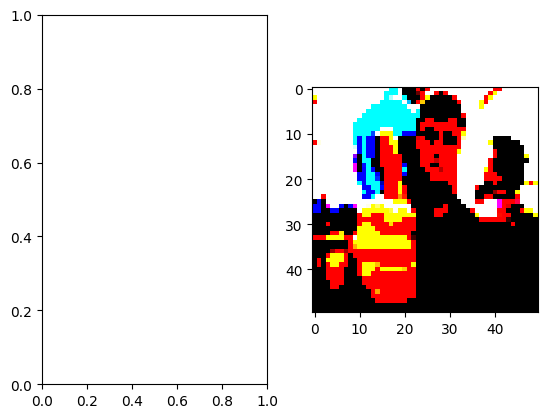

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.imshow(d[0,9,:,:,:])
# axes[1].imshow(d[3,15,:,:,:])

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [46]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [47]:
# function to create 3D Model, compile, print summary and return
def create_model(frames, image_height, image_width, num_classes):
        model = Sequential()

        model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(frames, image_height, image_width, 3), activation='relu'))
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(BatchNormalization())

        model.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(BatchNormalization())

        model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(BatchNormalization())

        model.add(Flatten())

        model.add(Dense(128, activation='relu'))
        model.add(Dense(num_classes, activation='softmax'))

        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())

        return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [48]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
shape_h = 50
shape_w = 50
batch_size = 1
num_classes = 5

model = create_model(frames, shape_h, shape_w, num_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 50, 50, 16)    1312      
                                                                 
 max_pooling3d (MaxPooling3  (None, 5, 25, 25, 16)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 5, 25, 25, 16)     64        
 Normalization)                                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 25, 25, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 2, 12, 12, 32)     0         
 g3D)                                                            
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [49]:
train_generator = generator(train_path, train_doc, batch_size, img_idx, shape_h, shape_w)
val_generator = generator(val_path, val_doc, batch_size, img_idx, shape_h, shape_w)

In [50]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [51]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [52]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-52-7f8f9d39394d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/train ; batch size = 1
Epoch 1/15
663/663 [==============================] - ETA: 0s - loss: 1.7302 - categorical_accuracy: 0.4178Source path =  /content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/val ; batch size = 1

Epoch 1: saving model to model_init_2024-03-0203_30_11.264188/model-00001-1.73018-0.41780-2.56979-0.52000.h5
663/663 [==============================] - 1988s 3s/step - loss: 1.7302 - categorical_accuracy: 0.4178 - val_loss: 2.5698 - val_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


663/663 [==============================] - ETA: 0s - loss: 0.9812 - categorical_accuracy: 0.6486
Epoch 2: saving model to model_init_2024-03-0203_30_11.264188/model-00002-0.98116-0.64857-1.73873-0.61000.h5
663/663 [==============================] - 182s 275ms/step - loss: 0.9812 - categorical_accuracy: 0.6486 - val_loss: 1.7387 - val_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 3/15
663/663 [==============================] - ETA: 0s - loss: 0.5640 - categorical_accuracy: 0.7873
Epoch 3: saving model to model_init_2024-03-0203_30_11.264188/model-00003-0.56399-0.78733-1.20258-0.67000.h5
663/663 [==============================] - 183s 276ms/step - loss: 0.5640 - categorical_accuracy: 0.7873 - val_loss: 1.2026 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 4/15
663/663 [==============================] - ETA: 0s - loss: 0.3500 - categorical_accuracy: 0.8808
Epoch 4: saving model to model_init_2024-03-0203_30_11.264188/model-00004-0.34996-0.88084-1.33042-0.65000.h5
663/663 [=======

Increasing Shape to 100 x 100

In [53]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
shape_h = 100
shape_w = 100
batch_size = 32
num_classes = 5

model = create_model(frames, shape_h, shape_w, num_classes)

train_generator = generator(train_path, train_doc, batch_size, img_idx, shape_h, shape_w)
val_generator = generator(val_path, val_doc, batch_size, img_idx, shape_h, shape_w)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 10, 100, 100, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 5, 50, 50, 16)     0         
 g3D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 5, 50, 50, 16)     64        
 chNormalization)                                                
                                                                 
 conv3d_4 (Conv3D)           (None, 5, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 2, 25, 25, 32)     0         
 g3D)                                                 

None
Source path =  /content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/train ; batch size = 32


<ipython-input-53-3205db2465d2>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
18/21 [========================>.....] - ETA: 38s - loss: 1.5031 - categorical_accuracy: 0.5312

<ipython-input-27-51f937640dd9>:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path +'/'+t[batch * batch_size + folder].split(';')[0] +'/'+imgs[item]).astype(np.float32)


21/21 [==============================] - ETA: 0s - loss: 1.3754 - categorical_accuracy: 0.5610 Source path =  /content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2024-03-0203_30_11.264188/model-00001-1.37543-0.56101-40.87386-0.25781.h5
21/21 [==============================] - 323s 15s/step - loss: 1.3754 - categorical_accuracy: 0.5610 - val_loss: 40.8739 - val_categorical_accuracy: 0.2578 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.3172 - categorical_accuracy: 0.8810 
Epoch 2: saving model to model_init_2024-03-0203_30_11.264188/model-00002-0.31717-0.88095-27.54822-0.32031.h5
21/21 [==============================] - 313s 15s/step - loss: 0.3172 - categorical_accuracy: 0.8810 - val_loss: 27.5482 - val_categorical_accuracy: 0.3203 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.1486 - categorical_accuracy: 0.9539 
Epoch 3: sav

As the difference between Categorical Accuracy (1.0) and ValidationAccuracy (0.89) is high, we will introduce dropout to overcome overfitting

In [55]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
shape_h = 100
shape_w = 100
batch_size = 32
num_classes = 5

model = Sequential()

model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(frames, shape_h, shape_w, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size, img_idx, shape_h, shape_w)
val_generator = generator(val_path, val_doc, batch_size, img_idx, shape_h, shape_w)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 10, 100, 100, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 5, 50, 50, 16)     0         
 g3D)                                                            
                                                                 
 dropout (Dropout)           (None, 5, 50, 50, 16)     0         
                                                                 
 batch_normalization_6 (Bat  (None, 5, 50, 50, 16)     64        
 chNormalization)                                                
                                                                 
 conv3d_7 (Conv3D)           (None, 5, 50, 50, 32)     13856     
                                                      

None
Source path =  /content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/train ; batch size = 32


<ipython-input-55-e873915e7a50>:61: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
18/21 [========================>.....] - ETA: 38s - loss: 2.1167 - categorical_accuracy: 0.3038

<ipython-input-27-51f937640dd9>:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path +'/'+t[batch * batch_size + folder].split(';')[0] +'/'+imgs[item]).astype(np.float32)


21/21 [==============================] - ETA: 0s - loss: 2.0724 - categorical_accuracy: 0.3170 Source path =  /content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2024-03-0203_30_11.264188/model-00001-2.07242-0.31696-16.45743-0.21875.h5
21/21 [==============================] - 322s 15s/step - loss: 2.0724 - categorical_accuracy: 0.3170 - val_loss: 16.4574 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.4417 - categorical_accuracy: 0.4598 
Epoch 2: saving model to model_init_2024-03-0203_30_11.264188/model-00002-1.44172-0.45982-7.22716-0.25781.h5
21/21 [==============================] - 313s 15s/step - loss: 1.4417 - categorical_accuracy: 0.4598 - val_loss: 7.2272 - val_categorical_accuracy: 0.2578 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.2483 - categorical_accuracy: 0.5119 
Epoch 3: savin

Due to the low validation accuracy above,
- batch_size = 64
- changing the architecture to start with 32 going into 256
- ReduceLROnPlateau

In [56]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
shape_h = 100
shape_w = 100
batch_size = 64
num_classes = 5

model = Sequential()

model.add(Conv3D(32, (3,3,3), padding='same', input_shape=(frames, shape_h, shape_w, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(128, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size, img_idx, shape_h, shape_w)
val_generator = generator(val_path, val_doc, batch_size, img_idx, shape_h, shape_w)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 10, 100, 100, 32   2624      
                             )                                   
                                                                 
 max_pooling3d_9 (MaxPoolin  (None, 5, 50, 50, 32)     0         
 g3D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 5, 50, 50, 32)     0         
                                                                 
 batch_normalization_9 (Bat  (None, 5, 50, 50, 32)     128       
 chNormalization)                                                
                                                                 
 conv3d_10 (Conv3D)          (None, 5, 50, 50, 64)     55360     
                                                      

None
Source path =  /content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/train ; batch size = 64


<ipython-input-56-87c5200d4b50>:61: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
 8/11 [====================>.........] - ETA: 2:11 - loss: 2.2502 - categorical_accuracy: 0.3145

<ipython-input-27-51f937640dd9>:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path +'/'+t[batch * batch_size + folder].split(';')[0] +'/'+imgs[item]).astype(np.float32)


11/11 [==============================] - ETA: 0s - loss: 2.1049 - categorical_accuracy: 0.3466 Source path =  /content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2024-03-0203_30_11.264188/model-00001-2.10489-0.34659-39.72845-0.26562.h5
11/11 [==============================] - 542s 49s/step - loss: 2.1049 - categorical_accuracy: 0.3466 - val_loss: 39.7285 - val_categorical_accuracy: 0.2656 - lr: 0.0010
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - ETA: 0s - loss: 1.2166 - categorical_accuracy: 0.5668 
Epoch 2: saving model to model_init_2024-03-0203_30_11.264188/model-00002-1.21663-0.56676-33.10248-0.23438.h5
11/11 [==============================] - 575s 53s/step - loss: 1.2166 - categorical_accuracy: 0.5668 - val_loss: 33.1025 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 0.9470 - categorical_accuracy: 0.6136 
Epoch 3: saving model to model_init_2024-03-0203_30_11.264188/model-00003-0.94702-0.61364-32.01754-0.23438.h5
11/11 [==============================] - 577s 53s/step - loss: 0.9470 - categorical_accuracy: 0.6136 - val_loss: 32.0175 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 4/15
11/11 [==============================] - ETA: 0s - loss: 0.8625 - categorical_accuracy: 0.6861 
Epoch 4: saving model to model_init_2024-03-0203_30_11.264188/model-00004-0.86253-0.68608-23.67972-0.19531.h5
11/11 [===============